In [171]:
import pandas as pd
from datetime import datetime
from sqlalchemy import create_engine

In [209]:
def get_raw_data():
    """Get raw data from local database"""
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        birthdates = pd.read_sql_table('birthdates', con)
        genetics = pd.read_sql_table('genetics', con)
        classification = pd.read_sql_table('classification', con)
        
    return milk, birthdates, genetics, classification

def transform_milk(data):
    """Transform milk features"""
    features = ['animal_id','date','milk_weight']
    return data[features]

def transform_genetics(data):
    """Transform and select genetics features"""
    data = data.drop(axis=1, labels=['name'])
    print(data.columns)
    features = ['animal_id', 'milk', 'ctpi', 'udc']
    data = data.drop_duplicates(subset=['animal_id'], keep='last')
    return data.fillna(data.mean())[features]

def transform_classification(data):
    """Transform and select classification features"""
    data = data.drop(axis=1, labels=['category', 'age', 'date_calved', 'date'])
    print(data.columns)
    features = ['animal_id', 'final_score', 'breed_age_average']
    data = data.drop_duplicates(subset=['animal_id'], keep='last')
    return data.fillna(data.mean())[features]

def number_of_days_in_period(start, end):
    """Gets number of days between two string dates"""
    end = datetime.strptime(end, '%m-%d-%Y')
    start = datetime.strptime(start, '%m-%d-%Y')
    return (start - end).days

def build_performance_profiles_for_period(milk, birthdates, start='1-1-2016', end='12-31-2017'):
    """Build summary performance profiles for date range"""
    period_milk = milk.set_index('date')[start:end]
    period_milk = pd.merge(left=period_milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    
    days_in_period = number_of_days_in_period(start, end)
    
    profiles = []
    for animal_id in period_milk['animal_id'].unique():
        animal_milk_for_period = period_milk[period_milk['animal_id'] ==  animal_id]
        
        profile = {}
        profile['animal_id'] = animal_id 
        profile['days_milked'] = animal_milk_for_period.count()['animal_id']
        profile['total_milkweight'] = animal_milk_for_period['milk_weight'].sum()
        profile['daily_milkweight'] = round(animal_milk_for_period['milk_weight'].mean(), 2)
        
        birthdate = pd.to_datetime(animal_milk_for_period['birthdate'].values[0]).strftime('%m-%d-%Y')
        
        profile['days_aged'] = number_of_days_in_period(end, birthdate)
        
        profiles.append(profile)
        
    data = pd.DataFrame(profiles)
    data = data.sort_values('daily_milkweight')
    return data

def merge_data(performance_profiles, genetics, classification):
    """Merge datasets performance_profiles, genetics, classifications into single dataset"""
    data = pd.merge(left=performance_profiles, right=genetics, left_on='animal_id', right_on='animal_id')
    data = pd.merge(left=data, right=classification, left_on='animal_id', right_on='animal_id')
    return data

def get_dataset_for_analysis():
    """Get transformed dataset for PCA analysis"""
    milk, birthdates, genetics, classification = get_raw_data()
    
    milk = transform_milk(milk)

    performance_profiles = build_performance_profiles_for_period(milk, birthdates)
    
    genetics = transform_genetics(genetics)
    classification = transform_classification(classification)
    
    return merge_data(performance_profiles, genetics, classification)

In [210]:
data = get_dataset_for_analysis().sort_values('total_milkweight')
data = data[data['days_milked'] > 350]
count = data.count()['animal_id']
percentage = 0.1

top_ids = data.head(int(count * percentage))['animal_id']
bot_ids = data.tail(int(count * percentage))['animal_id']

Index(['level_0', 'index', 'animal_id', 'pro', '%p', 'fat', '%f', 'rel',
       'milk', 'scs', 'pl', 'dpr', 'type', 'udc', 'flc', 'ctpi'],
      dtype='object')
Index(['index', 'animal_id', 'lactation_count', 'stature', 'strength',
       'body_depth', 'dairy_form', 'rump_angle', 'rump_width',
       'rear_legs_side', 'rear_legs_rear', 'locomotion', 'foot_angle',
       'fore_udder', 'udder_height', 'udder_width', 'udder_cleft',
       'udder_depth', 'front_teat_placement', 'rear_teat_placement',
       'teat_length', 'udder_tilt', 'body_condition',
       'front_end_capacity_aggregate', 'dairy_strength_aggregate',
       'rump_aggregate', 'feet_and_legs_aggregate', 'udder_score_aggregate',
       'final_score', 'breed_age_average'],
      dtype='object')


In [211]:
from sklearn.preprocessing import StandardScaler

animal_ids = data['animal_id']

data = data.drop(axis=1, labels=['animal_id'])
scaled_data = StandardScaler().fit_transform(data)

In [212]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
sns.set('notebook')

def conduct_silhouette_average_analysis(data, k_max=11, title='title'):
    k_values = [x for x in range(2, k_max)]
    silhouette_averages = []
    for k in k_values:
        clusterer = KMeans(n_clusters=k, random_state=45)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_averages.append(silhouette_score(data, cluster_labels))

    ax = plt.plot(k_values, silhouette_averages)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Average')
    plt.title(title)
    plt.show()

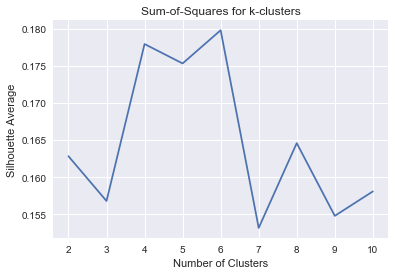

In [213]:
conduct_silhouette_average_analysis(scaled_data, k_max=11, title="Sum-of-Squares for k-clusters")
plt.savefig('figures/silhouette_score.png', dpi=300, bbox_inches='tight')

In [214]:
from sklearn.decomposition import PCA

def conduct_pca_and_kmeans_analysis(data, animal_ids, pca_components=2, n_clusters=5):
    random_state = 25
    pca_components = PCA(n_components=pca_components, random_state=random_state).fit_transform(data)
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(data)

    x = pca_components[:,0]
    y = pca_components[:,1]

    results = pd.DataFrame({'cluster_id':cluster_labels, 'x':x, 'y':y, 'animal_id':animal_ids})

    sns.lmplot('x', 'y', data=results, hue='cluster_id', fit_reg=False)
    _ = plt.title(f'Animal Clusters: k-means (k={n_clusters})')
    _ = plt.xlabel("")
    _ = plt.ylabel("")
    plt.show()
    
    return results

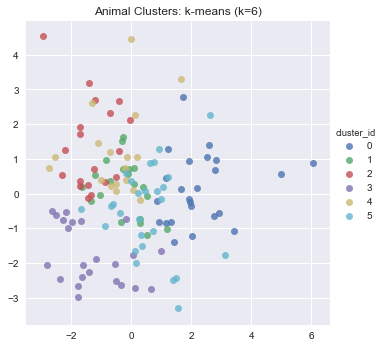

In [216]:
cluster_assignments = conduct_pca_and_kmeans_analysis(scaled_data, animal_ids, pca_components=2, n_clusters=6)
plt.savefig('figures/kmeans_clusters.png', dpi=300, bbox_inches='tight')

In [217]:
def generate_profile_results(assignments, top_ids=[], bottom_ids=[]):
    cluster_results = []
    for cluster_id in assignments['cluster_id'].unique():
        cluster_assignments = assignments[assignments['cluster_id'] == cluster_id]
        
        results = {}
        results['cluster_id'] = cluster_id
        results['count_total'] = cluster_assignments['animal_id'].count()
        results['top_total'] = cluster_assignments[cluster_assignments['animal_id'].isin(top_ids)].count()['animal_id']
        results['bot_total'] = cluster_assignments[cluster_assignments['animal_id'].isin(bottom_ids)].count()['animal_id']
        results['bot_percent'] = results['bot_total'] / results['count_total']
        results['top_percent'] = results['top_total'] / results['count_total']
        
        cluster_results.append(results)
        
    columns = ['cluster_id', 'count_total', 'top_total', 'bot_total', 'top_percent', 'bot_percent']
    return pd.DataFrame(cluster_results)[columns].sort_values('cluster_id').set_index('cluster_id')

generate_profile_results(cluster_assignments, top_ids, bot_ids)

,count_total,top_total,bot_total,top_percent,bot_percent
cluster_id,,,,,
0,24,0,10,0.000000,0.416667
1,20,0,0,0.000000,0.000000
2,19,0,0,0.000000,0.000000
3,23,11,0,0.478261,0.000000
4,18,2,1,0.111111,0.055556
5,27,0,2,0.000000,0.074074
